In [1]:
import os
from codes.bb import *
import pandas as pd
import networkx as nx
import plotly.express as px
import matplotlib.pyplot as plt

### Plot NMR Graph

In [2]:
def plot_graph(G):
    pos = nx.spring_layout(G)    
    node_color = ['y' if ':' in node else 'r' for node in G.nodes()]
    node_size = [800 if ':' in node else 300 for node in G.nodes()]
    nx.draw_networkx_nodes(G, pos, 
        node_size=node_size, 
        node_shape='o', 
        node_color=node_color)
    nx.draw_networkx_labels(G, pos, font_color='k', font_size=8)
    nx.draw_networkx_edges(G, pos)    
    plt.show()

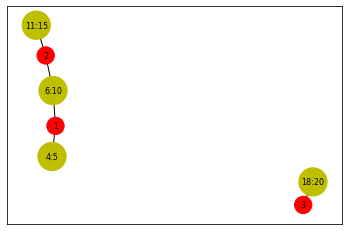

In [3]:
fnmr = '../DATA_TEST/testA.nmr'
# fnmr = '../DATA_EPSD_00_DMAX_60/1cza.nmr'
nmr = NMR(fnmr)
E, S = nmr.E, nmr.S
G = nmr.ordering_graph
plot_graph(G)

In [4]:
order_cost([3,2,1],E, S)

1036

### READ LOG FILES

In [2]:
WDIR = ['DATA_EPSD_00_DMAX_50', 'DATA_EPSD_00_DMAX_60']
df = []
for wdir in WDIR:
    dmax = int(wdir.split('_')[-1])
    for flog in sorted(os.listdir(wdir)):
        if not flog.endswith('.log'):
            continue
        pid = flog.replace('.log','')
        flog = os.path.join(wdir, flog)
        # check if the problem was pickled        
        df_log = {'pid': pid, 'dmax':dmax, 'flog': flog}
        with open(flog, 'r') as fid:
            for row in fid:
                row = row.replace(':','').replace('\n','').split(' ')
                field = row[1]
                if 'fnmr' in field:
                    value = row[-1]
                elif 'timeoutBB' in field:
                    value = int(row[-1])
                elif 'time' in field:
                    value = float(row[-1])
                else:
                    value = int(row[-1])
                df_log[field] = value
        if ('costSBBU' in df_log) and (df_log['costSBBU'] == df_log['costRELAX']):
            df_log['costBB'] = df_log['costSBBU']
            df_log['timeBB'] = df_log['timeSBBU']
        df.append(df_log)
df = pd.DataFrame(df)
df['gapRL'] = (df['costSBBU'] - df['costRELAX']) / df['costRELAX']
df['gapBB'] = (df['costSBBU'] - df['costBB']) / df['costBB']
fname = 'results.xlsx'
print('Save', fname)
df.to_excel(fname,index=False)
df.head()

Save results.xlsx


,pid,dmax,flog,fnmr,clean_log,tmax,nnodes,lenE,lenS,costRELAX,costSBBU,timeSBBU,timeoutBB,costBB,timeBB,gapRL,gapBB
0,1adx,50,DATA_EPSD_00_DMAX_50/1adx.log,DATA_EPSD_00_DMAX_50/1adx.nmr,1,5,120,305,117,234,234,0.0,0.0,234.0,0.0,0.0,0.0
1,1all,50,DATA_EPSD_00_DMAX_50/1all.log,DATA_EPSD_00_DMAX_50/1all.nmr,1,5,480,2009,477,954,954,0.0,0.0,954.0,0.0,0.0,0.0
2,1bdo,50,DATA_EPSD_00_DMAX_50/1bdo.log,DATA_EPSD_00_DMAX_50/1bdo.nmr,1,5,241,628,238,476,476,0.0,0.0,476.0,0.0,0.0,0.0
3,1cza,50,DATA_EPSD_00_DMAX_50/1cza.log,DATA_EPSD_00_DMAX_50/1cza.nmr,1,5,2694,9375,2691,5382,5382,0.0,0.0,5382.0,0.0,0.0,0.0
4,1epw,50,DATA_EPSD_00_DMAX_50/1epw.log,DATA_EPSD_00_DMAX_50/1epw.nmr,1,5,3861,11614,3857,7716,7716,1.0,0.0,7716.0,1.0,0.0,0.0


In [5]:
flog

'DATA_EPSD_00_DMAX_50/1adx.log'

In [ ]:
df.groupby(by=['pid','dmax']).mean()

In [ ]:
df50 = df[df['dmax']==50]
df60 = df[df['dmax']==60]